# 用水量預測（區域 + 辦公室）LSTM 模型

In [8]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
class EnergyDataset(Dataset):
    def __init__(self, values, months, seq_length):
        self.values = values
        self.months = months
        self.seq_length = seq_length

    def __len__(self):
        return len(self.values) - self.seq_length

    def __getitem__(self, idx):
        x_val = self.values[idx:idx+self.seq_length]             # shape: (seq,)
        x_mon = self.months[idx:idx+self.seq_length]             # shape: (seq, 2)

        # 保證形狀正確
        x_val = x_val.view(-1, 1)                                # shape: (seq, 1)
        x = torch.cat([x_val, x_mon], dim=1)                     # shape: (seq, 3)

        y = self.values[idx + self.seq_length].unsqueeze(-1)     # shape: (1,)
        return x, y


class EnergyPredictorLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout=0.2):
        super(EnergyPredictorLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        if x.dim() == 4:
            x = x.squeeze(-1)
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [10]:
def train_lstm(train_data, month_array, seq_length=12, epochs=100, show_loss_curve=True, model_name="predict_lstm"):
    # Normalize water usage
    scaler = MinMaxScaler()
    values_scaled = scaler.fit_transform(train_data.reshape(-1, 1))
    values_tensor = torch.tensor(values_scaled, dtype=torch.float32)

    # Encode month as sin/cos
    month_array = np.array(month_array)
    month_sin = np.sin(2 * np.pi * month_array / 12)
    month_cos = np.cos(2 * np.pi * month_array / 12)
    month_features = torch.tensor(np.stack([month_sin, month_cos], axis=1), dtype=torch.float32)

    # Dataset + Model
    dataset = EnergyDataset(values_tensor, month_features, seq_length)
    loader = DataLoader(dataset, batch_size=4, shuffle=True)

    # ✅ 使用更強大的模型參數
    model = EnergyPredictorLSTM(input_size=3, hidden_size=256, num_layers=4, dropout=0.3).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    epoch_losses = []

    for epoch in tqdm(range(epochs), desc=f"Training {model_name or ''}"):
        running_loss = 0.0
        for x_batch, y_batch in loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            output = model(x_batch)
            loss = criterion(output, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_losses.append(running_loss / len(loader))

    if show_loss_curve:
        plt.figure(figsize=(8, 4))
        plt.plot(range(1, epochs + 1), epoch_losses, marker='o')
        plt.title("Training Loss Over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    if model_name:
        torch.save(model.state_dict(), f"{model_name}.pt")
        print(f"[✓] Model saved as {model_name}.pt")

    return model, scaler

In [11]:
def multi_step_forecast(model, scaler, history_data, history_months, steps=2, seq_length=12):
    model.eval()

    # Prepare input
    values_scaled = scaler.transform(history_data[-seq_length:].reshape(-1, 1))
    month_array = np.array(history_months[-seq_length:])
    month_sin = np.sin(2 * np.pi * month_array / 12)
    month_cos = np.cos(2 * np.pi * month_array / 12)
    month_features = np.stack([month_sin, month_cos], axis=1)

    seq_input = torch.tensor(np.concatenate([values_scaled, month_features], axis=1), dtype=torch.float32).unsqueeze(0).to(device)

    predictions = []
    next_month = history_months[-1]
    with torch.no_grad():
        for _ in range(steps):
            pred = model(seq_input).item()
            pred_orig = scaler.inverse_transform(np.array([[pred]]))[0, 0]
            predictions.append(pred_orig)

            next_month = 1 if next_month == 12 else next_month + 1
            sin_next = np.sin(2 * np.pi * next_month / 12)
            cos_next = np.cos(2 * np.pi * next_month / 12)
            new_entry = torch.tensor([[[pred, sin_next, cos_next]]], dtype=torch.float32).to(device)
            seq_input = torch.cat((seq_input[:, 1:, :], new_entry), dim=1)

    return predictions

In [12]:
def process_series_and_forecast(series, months, forecast_steps=12):
    model, scaler = train_lstm(series, months, model_name="predict_lstm")
    predictions = multi_step_forecast(model, scaler, series, months, steps=forecast_steps)
    return predictions

Training predict_lstm:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1, 1])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Training predict_lstm: 100%|██████████| 100/100 [00:03<00:00, 32.10it/s]


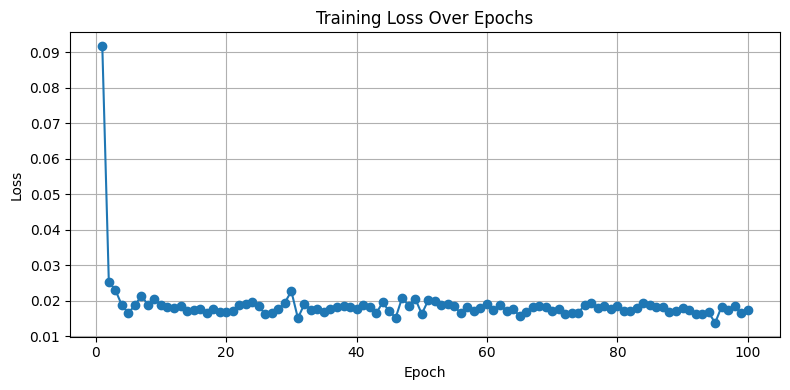

[✓] Model saved as predict_lstm.pt


Training predict_lstm:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1, 1])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Training predict_lstm: 100%|██████████| 100/100 [00:03<00:00, 32.20it/s]


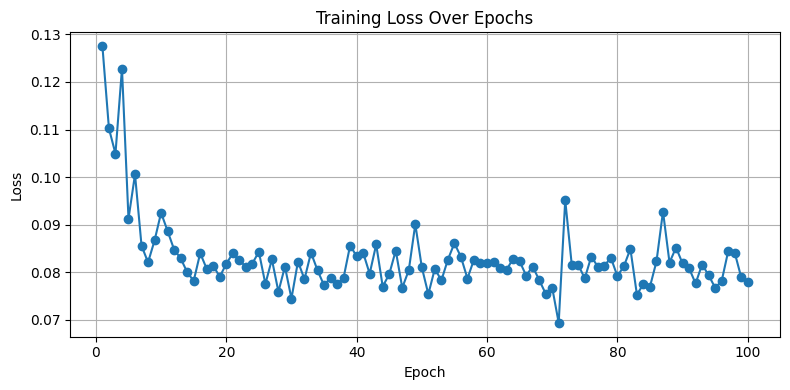

[✓] Model saved as predict_lstm.pt


In [13]:
water_file_path = "Monthly_Water_2021-2023.xlsx"
electricity_file_path = "Monthly_electricity_2021-2023.xlsx"
df_water = pd.read_excel(water_file_path, sheet_name="Sheet1")
df_electricity = pd.read_excel(electricity_file_path, sheet_name="Sheet1")

water_columns = ['Total_Water(ML)']
electricity_columns = ['Total Electricity Consumption (kWh)']
forecast_steps = 3  # 預測未來 3 個月

# 預測各區域
water_forecasts = {}
for col in water_columns:
    series = df_water[col].dropna().values
    valid_idx = df_water[col].dropna().index
    months = df_water.loc[valid_idx, 'Month'].values
    water_forecasts[col] = process_series_and_forecast(series, months, forecast_steps=forecast_steps)

# 預測各辦公室
electricity_forecasts = {}
for col in electricity_columns:
    series = df_electricity[col].dropna().values
    valid_idx = df_electricity[col].dropna().index
    months = df_electricity.loc[valid_idx, 'Month'].values
    electricity_forecasts[col] = process_series_and_forecast(series, months, forecast_steps=forecast_steps)

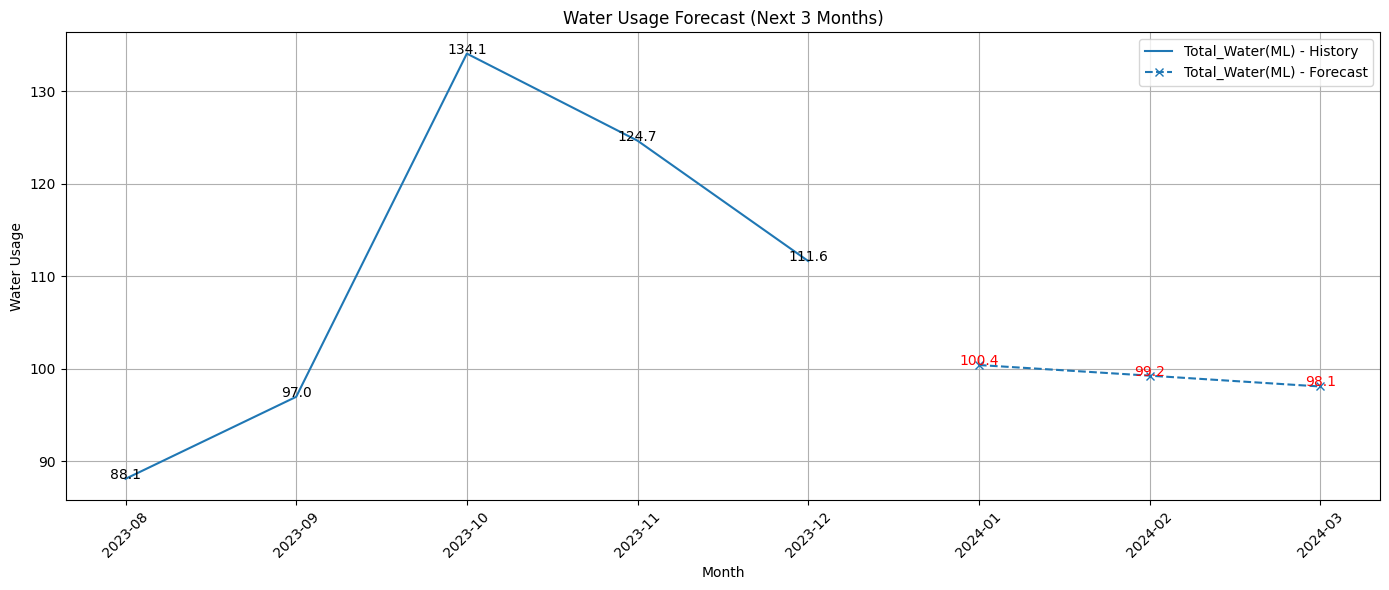

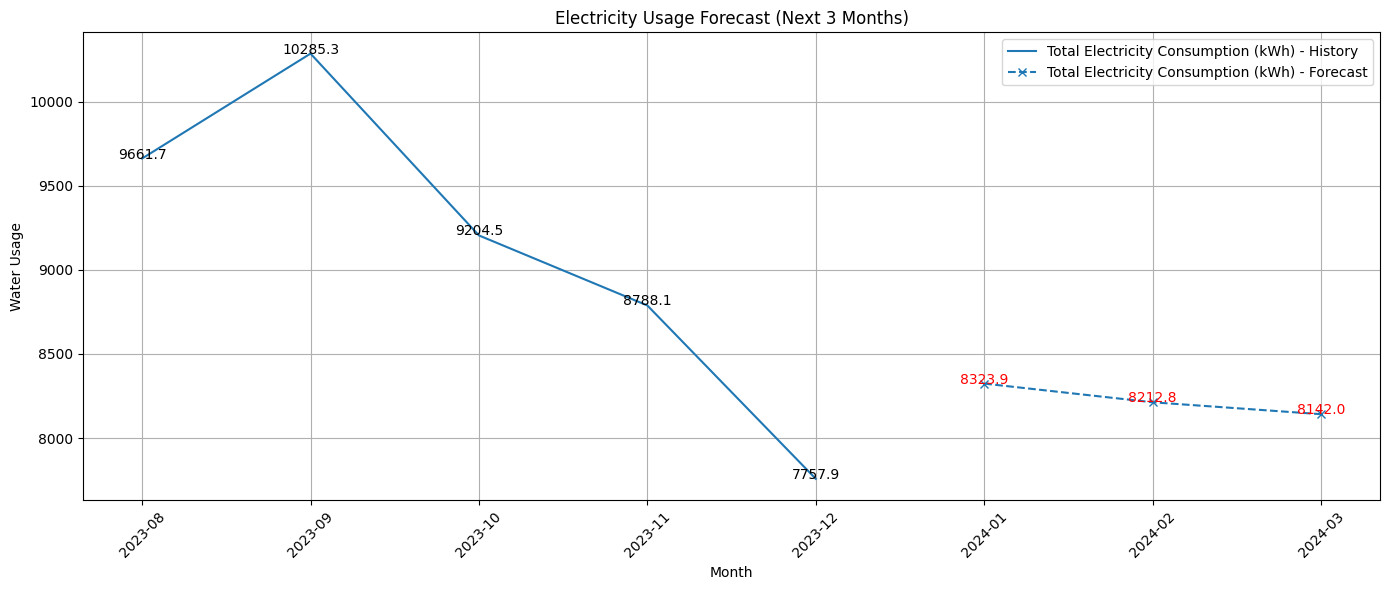

In [14]:
def plot_forecasts(history_df, forecasts, title, date_df=None, forecast_steps=12):
    plt.figure(figsize=(14, 6))
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    color_map = {}
    color_index = 0

    for col in forecasts:
        full_series = history_df[col].dropna().values
        history_tail = full_series[-5:]
        prediction = forecasts[col]

        # 統一顏色
        if col not in color_map:
            color_map[col] = color_cycle[color_index % len(color_cycle)]
            color_index += 1
        color = color_map[col]

        # X 軸標籤處理
        if date_df is not None:
            # 強化防呆：缺失值填入預設值
            months_str = date_df['Month'].fillna(1).astype(int).astype(str).str.zfill(2)
            years_str = date_df['Year'].fillna(2000).astype(int).astype(str)
            dates = pd.to_datetime(years_str + '-' + months_str, format="%Y-%m")

            label_dates = dates.iloc[-5:].tolist()
            last_date = label_dates[-1]
            for i in range(1, forecast_steps + 1):
                next_month = last_date + pd.DateOffset(months=i)
                label_dates.append(next_month)
            x_labels = [d.strftime("%Y-%m") for d in label_dates]
        else:
            x_labels = [f"T-{5 - i}" for i in range(5)] + [f"F+{i+1}" for i in range(forecast_steps)]

        # 畫線
        plt.plot(range(5), history_tail, label=f"{col} - History", color=color)
        plt.plot(range(5, 5 + forecast_steps), prediction, 'x--', label=f"{col} - Forecast", color=color)

        # 數值標註
        for i, v in enumerate(history_tail):
            plt.text(i, v, f"{v:.1f}", ha='center', fontsize=10)
        for i, v in zip(range(5, 5 + forecast_steps), prediction):
            plt.text(i, v, f"{v:.1f}", ha='center', fontsize=10, color='red')

    plt.title(title)
    plt.xlabel("Month")
    plt.ylabel("Water Usage")
    plt.xticks(ticks=range(5 + forecast_steps), labels=x_labels, rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 畫圖
plot_forecasts(df_water[water_columns], water_forecasts, "Water Usage Forecast (Next 3 Months)", date_df=df_water[['Year', 'Month']], forecast_steps=forecast_steps)
plot_forecasts(df_electricity[electricity_columns], electricity_forecasts, "Electricity Usage Forecast (Next 3 Months)", date_df=df_electricity[['Year', 'Month']], forecast_steps=forecast_steps)

In [52]:
# =========  新增區塊：載入已儲存模型並預測下一個月  =========

def load_trained_model(model_path):
    """
    建立與訓練時相同架構的 LSTM，並載入權重。
    """
    model = EnergyPredictorLSTM(input_size=3, hidden_size=256,
                                num_layers=4, dropout=0.3).to(device)
    state = torch.load(model_path, map_location=device)
    model.load_state_dict(state)
    model.eval()
    return model

def predict_next_month(series, months, model_path):
    """
    使用指定的 .pt 檔，根據歷史 series / months 預測下一個月。
    回傳單一 float。
    """
    # 1️⃣ 重新擬合 scaler（用完整歷史資料）
    scaler = MinMaxScaler()
    scaler.fit(series.reshape(-1, 1))

    # 2️⃣ 載入模型
    model = load_trained_model(model_path)

    # 3️⃣ multi-step 預測（只取 steps=1）
    next_val = multi_step_forecast(model, scaler,
                                   history_data=series,
                                   history_months=months,
                                   steps=1)[0]
    return next_val

# ----------  路徑 & 欄位設定 ----------
water_model_path = "predict_lstm.pt"          # ← 依實際檔名修改
elec_model_path  = "predict_lstm.pt"           # ← 依實際檔名修改

water_col = 'Total_Water(ML)'
elec_col  = 'Total Electricity Consumption (kWh)'

# ----------  準備資料 ----------
series_water = df_water[water_col].dropna().values
months_water = df_water.loc[df_water[water_col].dropna().index, 'Month'].values

series_elec = df_electricity[elec_col].dropna().values
months_elec = df_electricity.loc[df_electricity[elec_col].dropna().index, 'Month'].values

# ----------  預測 ----------
next_water = predict_next_month(series_water, months_water, water_model_path)
next_elec  = predict_next_month(series_elec, months_elec, elec_model_path)

# ----------  輸出 ----------
print(f"🔹 本月用水量：{series_water[-1]:,.2f} ML")
print(f"🔹 本月用電量：{series_elec[-1]:,.2f} kWh")
print(f"🔹 下個月預估用水量：{next_water:,.2f} ML")
print(f"🔹 下個月預估用電量：{next_elec:,.2f} kWh")


<class 'numpy.ndarray'>
[ 1  2  3  4  5  6  7  8  9 10 11 12  1  2  3  4  5  6  7  8  9 10 11 12
  1  2  3  4  5  6  7  8  9 10 11 12]
🔹 本月用水量：111.63 ML
🔹 本月用電量：7,757.88 kWh
🔹 下個月預估用水量：94.55 ML
🔹 下個月預估用電量：8,323.88 kWh


In [46]:
# =========  LLM載入 =========
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

model_name="Qwen/Qwen2-1.5B-Chat"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
     model_name,
     torch_dtype=torch.float16,
     device_map="auto"
     )

============ 用水 / 用電 預測概覽 ============
🔹 本月用水量：111.63 ML
🔹 下月預估用水量：94.55 ML（下降 -15.3%）
🔹 本月用電量：7,757.88 kWh
🔹 下月預估用電量：8,323.88 kWh（上升 +7.3%）

============ 建議 ============
你是一位節能與節水顧問，請依據以下數據提供 3~4 句繁體中文建議。
- 本月用水 111.63 ML，預估下月 94.55 ML，下降 -15.3%
- 本月用電 7757.88 kWh，預估下月 8323.88 kWh，上升 +7.3%
建議要具體、可行，並避免制式口號。 1. 隨著時間推移，我們需要採取措施來節約用水和電力使用，以降低能源消耗和成本。
2. 建議可以考慮改進用水習慣，例如洗菜時盡量避免長流水，以及合理安排家庭日常活動，減少不必要的用水需求。
3. 节省能源是每個人都應該做的，透過更有效的使用設備和改善家居環境，我們可以在不犧牲生活品質的同時，實現節能的目的。
4. 在預算有限的情況下，投資在節能技術上可以帶來顯著的能源節省效益，同時也能為未來的能源開支留下更多的空間。建議可以考慮安裝熱水器自動切換系統，或者採用低


In [49]:
def generate_advice(prompt, tokenizer=tokenizer, model=model, max_new_tokens=160):
    """
    使用小型 LLM 產生繁體中文建議。
    """

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=0.7,
            top_p=0.9
        )
    advice = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return advice.strip()

# ----------  計算趨勢 ----------
curr_water = series_water[-1]
curr_elec  = series_elec[-1]

water_diff = next_water - curr_water
elec_diff  = next_elec  - curr_elec

water_pct = water_diff / curr_water * 100
elec_pct  = elec_diff  / curr_elec  * 100

trend_water = "上升" if water_diff > 1e-3 else "下降" if water_diff < -1e-3 else "持平"
trend_elec  = "上升" if elec_diff  > 1e-3 else "下降" if elec_diff  < -1e-3 else "持平"

# ----------  輸出 ----------
print("============ 用水 / 用電 預測概覽 ============")
print(f"🔹 本月用水量：{curr_water:,.2f} ML")
print(f"🔹 下月預估用水量：{next_water:,.2f} ML（{trend_water} {water_pct:+.1f}%）")
print(f"🔹 本月用電量：{curr_elec:,.2f} kWh")
print(f"🔹 下月預估用電量：{next_elec:,.2f} kWh（{trend_elec} {elec_pct:+.1f}%）")

# ----------  LLM 建議 ----------
prompt = (
    f"你是一位節能與節水顧問，請依據以下數據條列3點繁體中文建議。\n"
    f"- 本月用水 {curr_water:.2f} ML，預估下月 {next_water:.2f} ML，{trend_water} {water_pct:+.1f}%\n"
    f"- 本月用電 {curr_elec:.2f} kWh，預估下月 {next_elec:.2f} kWh，{trend_elec} {elec_pct:+.1f}%\n"
    f"可以從一些日常習慣與常見的電器使用方式來建議。"
)

advice = generate_advice(prompt)
print("\n============ 建議 ============")
print(advice)
print("================================")


============ 用水 / 用電 預測概覽 ============
🔹 本月用水量：111.63 ML
🔹 下月預估用水量：94.55 ML（下降 -15.3%）
🔹 本月用電量：7,757.88 kWh
🔹 下月預估用電量：8,323.88 kWh（上升 +7.3%）

============ 建議 ============
你是一位節能與節水顧問，請依據以下數據條列3點繁體中文建議。
- 本月用水 111.63 ML，預估下月 94.55 ML，下降 -15.3%
- 本月用電 7757.88 kWh，預估下月 8323.88 kWh，上升 +7.3%
可以從一些日常習慣與常見的電器使用方式來建議。以下三點是關於節能和節水的建議：

1. 調整家中的溫控設定：在使用家用設備時，例如冰箱、空調等，適當調整溫度設定，可以減少能源的消耗。例如，將冷氣機的溫度設定為20度或更低，將熱水器的溫度設定為60度以上。

2. 使用節能燈泡：LED燈泡比傳統白熾燈泡節能許多倍，而且光效更高。此外，還可以用較低功率的燈泡代替高功率的燈泡，以減少能源消耗。

3. 定期檢查和維護家中的設施：定期清潔家中的設備，例如水管、水龙头和排水管


In [50]:
# =========  寫入 JSON =========
import json
from datetime import datetime

# 將要儲存的欄位整理成 dict
result_dict = {
    "本月用水量": f"{curr_water:,.2f} ML",
    "下月預估用水量": f"{next_water:,.2f} ML（{trend_water} {water_pct:+.1f}%）",
    "本月用電量": f"{curr_elec:,.2f} kWh",
    "下月預估用電量": f"{next_elec:,.2f} kWh（{trend_elec} {elec_pct:+.1f}%）",
    "LLM建議": advice
}

output_path = "predict_summary.json"
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(result_dict, f, ensure_ascii=False, indent=2)

print(f"✅ 已將結果存成 JSON：{output_path}")


✅ 已將結果存成 JSON：predict_summary.json
